# Imports

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime
from bs4 import BeautifulSoup
import requests

from pyomo.environ import AbstractModel, ConcreteModel, SolverFactory
from pyomo.environ import Set, Constraint, Objective, Param, Var
from pyomo.environ import Binary
from pyomo.environ import minimize, maximize
from pyomo.environ import value

import warnings
warnings.filterwarnings('ignore')


# Functions

In [2]:

def load_data(filepath):
    df = pd.read_excel(filepath, engine='openpyxl')
    return df


def clean_data(data):
    # Drop columns with null values
    data_cleaned = data.dropna(inplace=False)

    #clean up Oz column 
    data_cleaned.rename(columns = {'#Oz':'Oz'}, inplace = True)
    data_cleaned['Oz'] = data_cleaned['Oz'].replace(regex=[r'\D+'], value="")
    data_cleaned['Oz'] = round(data_cleaned['Oz'].astype(float), 2)
    
    # Clean number of shipments column
    data_cleaned['Number of Shipments'] = pd.to_numeric(data_cleaned['Number of Shipments'], errors = 'coerce')
    data_cleaned.dropna(inplace=True)
    data_cleaned['Number of Shipments'] = data_cleaned['Number of Shipments'].astype(int)
    data_cleaned['Number of Shipments'] = data_cleaned['Number of Shipments'].fillna(1)
    
    # Add pounds column
    data_cleaned['Pounds'] = round(data_cleaned['Oz'].astype(float) / 16, 2)
    
    # Determine average number of Pounds/Oz per shipment
    data_cleaned['Pounds_per_Shipment'] = round(data_cleaned['Pounds'] / data_cleaned['Number of Shipments'], 2)
    data_cleaned['Oz_per_Shipment'] = round(data_cleaned['Oz'] / data_cleaned['Number of Shipments'], 2)
    
    # Create a feature capturing the number of months since the last donation
    data_cleaned['DOLD'] = data_cleaned['DOLD'].replace('10/0/3/2019', '10/3/2019')
    data_cleaned['Current_Date'] = pd.to_datetime(date.today())
    data_cleaned['Months_since_last_donation'] = ((pd.to_datetime(data_cleaned['Current_Date']).dt.year - pd.to_datetime(data_cleaned['DOLD']).dt.year) * 12) + (pd.to_datetime(data_cleaned['Current_Date']).dt.month - pd.to_datetime(data_cleaned['DOLD']).dt.month)
    
    # Convert Dates to pd.Datetime
    data_cleaned['DOFD'] = pd.to_datetime(data_cleaned['DOFD'])
    data_cleaned['DOLD'] = pd.to_datetime(data_cleaned['DOLD'])
    
    # strip the origin column
    data_cleaned['Origin'] = data_cleaned['Origin'].str.strip()  
    
    # Add column to track if it was dropped off or not
    data_cleaned['droppedOff'] = data_cleaned['Origin'] != 'Shipped from Donor'
    
    # Return the cleaned data
    return data_cleaned


def generate_zip_data(data):
    # Get unique zipcodes
    zipcode_list = data['Zip code'].unique()

    # Scrape the coordinates
    latitude = []
    longitude = []
    
    for zip_code in zipcode_list:
        url = 'https://www.zipdatamaps.com/{}'.format(zip_code)
        html=requests.get(url)
        Soup =BeautifulSoup(html.content , 'html.parser')
        table = Soup.find(attrs={'class': "table table-striped table-bordered table-hover table-condensed"})
        
        data = [] 
        for i in table.find_all('tr'):
            data.append([j.text for j in i.find_all('td')])
        coord = data[-1][1:]
        
        lat, long = coord[0].split(',')
        latitude.append(lat)
        longitude.append(long)

    # Create the dataframe
    zipcode_df = pd.DataFrame({
        "Zip code": zipcode_list,
        "Latitude": latitude,
        "Longitude":longitude
    })
    
        
    # Return the zipcode dataframe
    return zipcode_df

In [3]:
def calculate_shipping_cost_pounds(weight_in_pounds=0):
    if(weight_in_pounds <= 2):
        return 41
    elif(weight_in_pounds <= 3):
        return 45.76
    elif(weight_in_pounds <= 4):
        return 49.92
    elif(weight_in_pounds <= 5):
        return 50.34 
    elif(weight_in_pounds <= 6):
        return 57.70
    elif(weight_in_pounds <= 7):
        return 58.44
    elif(weight_in_pounds <= 8):
        return 58.70
    elif(weight_in_pounds <= 9):
        return 59.49
    elif(weight_in_pounds <= 10):
        return 60.22
    elif(weight_in_pounds <= 11):
        return 70.75
    elif(weight_in_pounds <= 12):
        return 72.42
    elif(weight_in_pounds <= 13):
        return 72.68
    elif(weight_in_pounds <= 14):
        return 73.11
    elif(weight_in_pounds <= 15):
        return 73.37
    elif(weight_in_pounds <= 16):
        return 78.14
    elif(weight_in_pounds <= 17):
        return 82.62
    else:
        return 83.28
    
def calculate_shipping_cost_ounces(weight_in_ounces):
    # Convert weight to pounds 
    weight_in_pounds = weight_in_ounces / 16
    return calculate_shipping_cost_pounds(weight_in_pounds)
    

# Load and Clean / Aggregate the Data

In [4]:
path_to_data = os.path.join(os.getcwd(), 'NYMB_updates.xlsx')

# Load and clean the data
data = load_data(path_to_data)
data_cleaned = clean_data(data)

# Get coordinates for zipcodes
zipcode_df = generate_zip_data(data)

# Merge the datasets
data_cleaned = pd.merge(data_cleaned, zipcode_df, how='inner', on='Zip code')

# Reorganize the columns
data_cleaned = data_cleaned[['DOFD', 'DOLD', 'Neighborhood', 'Number of Shipments', 'Oz', 'Oz_per_Shipment', 'droppedOff']]

display(data_cleaned.head())

,DOFD,DOLD,Neighborhood,Number of Shipments,Oz,Oz_per_Shipment,droppedOff
0,2022-08-02,2022-08-02,Battery Park,1,247.00,247.00,False
1,2021-04-09,2021-05-07,Battery Park,2,603.00,301.50,False
2,2022-02-24,2022-02-24,Battery Park,1,493.84,493.84,False
3,2019-04-10,2019-05-10,Battery Park,3,596.00,198.67,True
4,2019-05-17,2019-05-17,Battery Park,1,360.00,360.00,False


In [5]:
data_agg = data_cleaned.copy()

# If DOFD != DOLD, use number of shipments to estimate the dates they shipped
# Assume Equally spaced shipments because we have nothing else to go off of
# If DOLD comes before DOFD, set them equal
data_agg.loc[(data_agg['DOLD'] - data_agg['DOFD']).dt.days < 0, 'DOLD'] = data_agg.loc[(data_agg['DOLD'] - data_agg['DOFD']).dt.days < 0, 'DOFD']

# Calculate the dates in the middle
all_dates = []
for i in range(data_agg.shape[0]):
    periods = data_agg.loc[i, 'Number of Shipments']
    dates = pd.to_datetime(pd.date_range(data_agg.iloc[i, :]['DOFD'], data_agg.iloc[i, :]['DOLD'], periods=periods).to_list())
    all_dates.append(dates)
    
data_agg['Dates'] = all_dates
data_agg = data_agg[['DOFD', 'DOLD', 'Dates', 'Neighborhood', 'Number of Shipments', 'Oz', 'droppedOff']]

# Adjust the Oz and Number of shipments based on the length of the new Dates column
data_agg['Oz'] = data_agg['Oz'] / data_agg['Number of Shipments']

# Explode the dataframe on the dates column
data_agg = data_agg.explode('Dates')
data_agg = data_agg.drop(columns=['DOFD', 'DOLD', 'Number of Shipments', 'droppedOff'], inplace=False)

data_agg


,Dates,Neighborhood,Oz
0,2022-08-02,Battery Park,247.000000
1,2021-04-09,Battery Park,301.500000
1,2021-05-07,Battery Park,301.500000
2,2022-02-24,Battery Park,493.840000
3,2019-04-10,Battery Park,198.666667
...,...,...,...
252,2022-03-01,Washington Heights (upper west side),276.000000
252,2022-04-22,Washington Heights (upper west side),276.000000
252,2022-06-13,Washington Heights (upper west side),276.000000
252,2022-08-04,Washington Heights (upper west side),276.000000


In [6]:
# Calculate the number of biweekly groups
num_biweekly_groups = pd.date_range(min(data_agg['Dates']), max(data_agg['Dates']), freq='2W')
num_biweekly_groups = len(num_biweekly_groups) - 1

# Calculate the biweekly total donations for each neighborhhod
biweekly_total_donations = data_agg.groupby(['Neighborhood', pd.Grouper(key='Dates', freq='SM')]).sum().reset_index()
biweekly_total_donations = biweekly_total_donations.sort_values(['Dates', 'Neighborhood'])
biweekly_total_donations[biweekly_total_donations['Neighborhood'] == 'Battery Park']

# Calculate Average Biweekly Donations for ecah neighborhood
avg_biweekly_donations = biweekly_total_donations.groupby('Neighborhood').sum().reset_index()
avg_biweekly_donations['Oz'] = avg_biweekly_donations['Oz'] / num_biweekly_groups
avg_biweekly_donations = avg_biweekly_donations.set_index('Neighborhood')

avg_biweekly_donations

,Oz
Neighborhood,
Battery Park,15.870976
Bowling Green,12.862073
Chelsea,50.354207
City Hall,3.439024
East Village,50.807073
Hamilton Heights (upper west side),14.962134
Harlem,48.150244
Inwood,13.548049
Lower East Side,3.507378


In [7]:
# Calculate some data
mean_shipment_amount = np.mean(data_cleaned['Oz_per_Shipment'])
neighborhoods = avg_biweekly_donations.index.values
avg_shipment_per_neighborhood = avg_biweekly_donations.to_dict()['Oz']

# Calculate the average amount that was shipped
total_shipped = data_cleaned[data_cleaned['droppedOff'] == False]['Oz'].sum()
total_donated = data_cleaned['Oz'].sum()
percentage_shipped = total_shipped / total_donated

# Calculate Shipping Costs
avg_biweekly_donations['ShippingCostPortion'] = avg_biweekly_donations['Oz'].apply(lambda x: calculate_shipping_cost_ounces(percentage_shipped * x))
avg_biweekly_donations['ShippingCostAll'] = avg_biweekly_donations['Oz'].apply(lambda x: calculate_shipping_cost_ounces(x))

shipping_costs_all = avg_biweekly_donations.to_dict()['ShippingCostAll']
shipping_cost_portion = avg_biweekly_donations.to_dict()['ShippingCostPortion']

# Model with Volunteer

## Formulation
### Important Notes:
- Fixed startup = $500
- Cost of shipment in Manhattan is the same, entirely dependent on weight of the shipment. **Consolidation is Key**. *Want to Attack places with the most donations ounces*

### Decision Variables: 
- Depo[n]: Binary Decision variable for each neighborhood of whether or not to place a milk bank 


### Objective: Minimize Cost
- Total_Cost = Creation_Cost + Shipping Costs

### Constraints
1. Between 2 - 5 Depos

### Assumptions we are making
- People will donate roughly the same whether they mail it in or drop it off
- Neighborhood donation rate will remain approximately the same in the future
- Percentage of people who drop off will remain roughly the same
- Assume shipping FedEx overnight
- Equally spaced shipments for people who have multiple on different dates



In [8]:
m = ConcreteModel()

# Sets
m.NEIGHBORHOODS = Set(initialize=neighborhoods)

# Inputs
m.min_depos = Param(initialize=2)
m.max_depos = Param(initialize=5)
m.depo_creation_cost = Param(initialize=500)
m.num_biweekly_segments = Param(initialize=21)

m.percentage_milk_dropped = Param(initialize=(1 - percentage_shipped))
m.avg_amount_per_box = Param(initialize=mean_shipment_amount) # TODO: Linda said average was 300, data shows 286. Can use either, currently using it form the data
m.avg_shipment_oz = Param(m.NEIGHBORHOODS, initialize=avg_shipment_per_neighborhood)

m.shipping_costs_all = Param(m.NEIGHBORHOODS, initialize=shipping_costs_all)
m.shipping_costs_portion = Param(m.NEIGHBORHOODS, initialize=shipping_cost_portion)

# Decision Variables
m.Depo = Var(m.NEIGHBORHOODS, domain=Binary)

# Constraints
def EnoughDepos_rule(m):
    return sum(m.Depo[n] for n in m.NEIGHBORHOODS) >= m.min_depos
m.EnoughDepos_constraint = Constraint(rule=EnoughDepos_rule)

def NotTooManyDepos_rule(m):
    return sum(m.Depo[n] for n in m.NEIGHBORHOODS) <= m.min_depos
m.NotTooManyDepos_rule = Constraint(rule=NotTooManyDepos_rule)

# Objective Function
def TotalCost_objective(m):
    # If depo == 0 --> (1 - (m.depo[n] * m.percentage_milk_dropped)) = 1
    # If depo == 1 --> (1 - (m.Depo[n] * m.percentage_milk_dropped)_ = % milk shipped 
    return sum(m.Depo[n]*m.depo_creation_cost + (m.Depo[n] * m.shipping_costs_portion[n] + (1-m.Depo[n])*m.shipping_costs_all[n])*m.num_biweekly_segments for n in m.NEIGHBORHOODS)
m.objective = Objective(rule=TotalCost_objective, sense=minimize)

In [9]:
# Solve the problem
solver = SolverFactory('glpk')
results = solver.solve(m)

# Print the results
print(results['Solver'])
print(m.objective.expr())


- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1
      Number of created subproblems: 1
  Error rc: 0
  Time: 0.0961599349975586

22866.649999999998


In [10]:
# NOTE: Seems to just pick the neighborhhods with the most amount of donations on average
# Maybe this is beneficial. Maybe we can look into different cost functions or more constraints
# NOTE: Looks Like Morningside Heights and Meatpacking Districts are the next choice. This is probably due to shipping costs

# TODO: Potentially add a new constraint for geographic distance 
# TODO: Does cost function need to multiply by 21 to get average yearly revenue
# TODO: Acknowledge that ShippingCostPortion == ShippingCostAll sometimes and think about how to fix this


for n in m.NEIGHBORHOODS:
    if(value(m.Depo[n] == 1)):
        print(n)        
        
display(avg_biweekly_donations.sort_values('Oz'))

Meatpacking District
Morningside Heights
upper east side
upper west side


,Oz,ShippingCostPortion,ShippingCostAll
Neighborhood,,,
Wall Street,0.621951,41.00,41.00
City Hall,3.439024,41.00,41.00
Lower East Side,3.507378,41.00,41.00
Midtown-East side,10.427561,41.00,41.00
NOHO,10.475610,41.00,41.00
Stuyvesant Park,10.862073,41.00,41.00
Roosevelt Island,12.347561,41.00,41.00
Bowling Green,12.862073,41.00,41.00
Inwood,13.548049,41.00,41.00


# Model Shipping Cost

In [11]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Get the shipping data
X = np.array([41,45.76,49.92,50.34,57.70,58.44,58.70,59.49,60.22,70.75,72.42,72.68,73.11,73.37,78.14,82.62,83.28])
y = np.arange(2, 19) # Weight in pounds

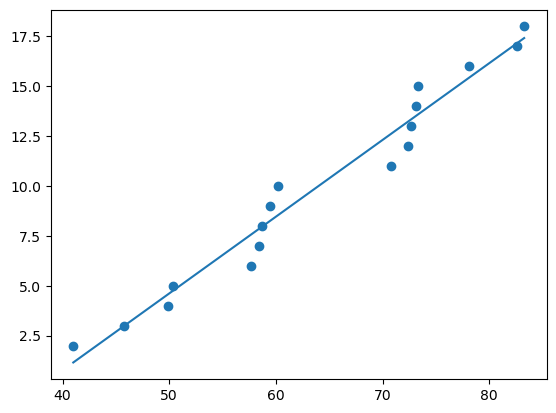

In [ ]:
# Model the data
model = LinearRegression()
model.fit(X.reshape(-1, 1), y)
preds = model.predict(X.reshape(-1, 1))

# Plot the data
plt.scatter(X, y)
plt.plot(X, preds)
plt.show()